# Preamble

In [370]:
libraries = c("dplyr","magrittr","tidyr","ggplot2","readxl","glue",
              "grid","gridExtra","zoo","RColorBrewer","scales","gganimate",
              "kableExtra","formattable","IRdisplay","foreach")
for(x in libraries) { library(x,character.only=TRUE,warn.conflicts=FALSE) }

# to show the plots as svg-graphics in Jupyter
# options(jupyter.plot_mimetypes = "image/svg+xml")
options(jupyter.plot_mimetypes = "image/png") 

if (Sys.info()[['sysname']]=='Windows') {
    windowsFonts(Times = windowsFont("Times New Roman"))
    theme_set(theme_bw(base_size=11,base_family='Times')) 
} else { theme_set(theme_bw(base_size=11)) }

'%&%' = function(x,y)paste0(x,y)

# registering cluster
cl = parallel::makeCluster(4)
doParallel::registerDoParallel(cl)

# (Fig 1) Epicurve

In [371]:
filename = "data.xlsx"

read_excel(filename, sheet = "Okinawa", range = cell_cols("G:H"), col_types = rep("date",2), col_names = TRUE) -> df_epicurve
colnames(df_epicurve) = c("onset","confirmed")
df_epicurve %<>% mutate(prefecture="Okinawa")

read_excel(filename, sheet = "Aichi", range = cell_cols("G:H"), col_types = rep("date",2), col_names = TRUE) -> df_epicurve_
colnames(df_epicurve_) = c("onset","confirmed")
df_epicurve_ %<>% mutate(prefecture="Aichi")
df_epicurve %<>% rbind(df_epicurve_)

read_excel(filename, sheet = "Tokyo", range = cell_cols("G:H"), col_types = rep("date",2), col_names = TRUE) -> df_epicurve_
colnames(df_epicurve_) = c("onset","confirmed")
df_epicurve_ %<>% mutate(prefecture="Tokyo")
df_epicurve %<>% rbind(df_epicurve_)

read_excel(filename, sheet = "Kanagawa", range = cell_cols("G:H"), col_types = rep("date",2), col_names = TRUE) -> df_epicurve_
colnames(df_epicurve_) = c("onset","confirmed")
df_epicurve_ %<>% mutate(prefecture="Kanagawa")
df_epicurve %<>% rbind(df_epicurve_)

df_epicurve %<>% 
    mutate(onset=as.Date(onset), confirmed=as.Date(confirmed))

df_epicurve %>% tail

onset,confirmed,prefecture
2018-04-29,2018-05-12,Aichi
2018-05-09,2018-05-12,Aichi
2018-05-12,2018-05-13,Aichi
2018-05-12,2018-05-18,Aichi
2018-05-06,2018-05-08,Tokyo
2018-04-19,2018-05-02,Kanagawa


In [372]:
Df_epicurve = data.frame(date=seq(as.Date('2018-03-14'),as.Date('2018-05-27'),by='1 day'))

df_epicurve %>% 
    group_by(prefecture,onset) %>%
    count %>%
    rename(i=n,date=onset) %>%
    ungroup %>%
    mutate(date=as.Date(date)) %>%
    spread(prefecture,i) %>%
    right_join(Df_epicurve,by="date") %>%
    mutate_if(is.numeric, funs(ifelse(is.na(.), 0, .))) -> df_onset

df_epicurve %>% 
    group_by(prefecture,confirmed) %>%
    count %>%
    rename(i=n,date=confirmed) %>%
    ungroup %>%
    mutate(date=as.Date(date)) %>%
    spread(prefecture,i) %>%
    right_join(Df_epicurve,by="date") %>%
    mutate_if(is.numeric, funs(ifelse(is.na(.), 0, .))) -> df_confirmed

df_confirmed %>% head(10)

date,Aichi,Kanagawa,Okinawa,Tokyo
2018-03-14,0,0,0,0
2018-03-15,0,0,0,0
2018-03-16,0,0,0,0
2018-03-17,0,0,0,0
2018-03-18,0,0,0,0
2018-03-19,0,0,0,0
2018-03-20,0,0,1,0
2018-03-21,0,0,0,0
2018-03-22,0,0,0,0
2018-03-23,0,0,0,0


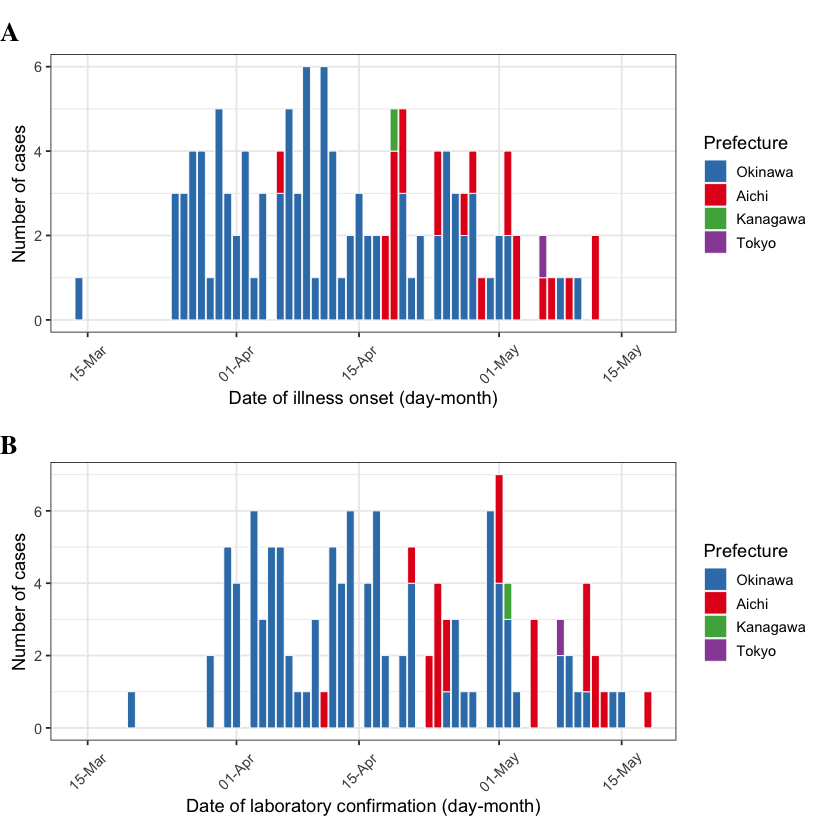

In [373]:
options(repr.plot.width=7,repr.plot.height=7)

cols <- c("Okinawa" = "#377eb8", "Aichi" = "#e41a1c", "Kanagawa" = "#4daf4a", "Tokyo" = "#984ea3")

df_confirmed %>%
    gather(Prefecture,c,-date) %>%
    mutate(Prefecture=factor(Prefecture, levels=c("Okinawa", "Aichi", "Kanagawa", "Tokyo") %>% rev)) %>%
    filter(c>0) %>%
    ggplot(aes(date,c,fill=Prefecture)) +
        geom_bar(stat = "identity",color="white",size=.25) +
        scale_fill_manual(values = cols) +
        coord_cartesian(xlim=c(as.Date("2018-03-14"),as.Date("2018-05-18"))) +
        scale_x_date(labels = date_format("%d-%b")) +
        labs(x="Date of laboratory confirmation (day-month)",y="Number of cases") +
        guides(fill = guide_legend(reverse=T)) +
        theme(legend.key.size = unit(.5, "cm"),
              axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              plot.title = element_text(size=11, hjust = 0.5, face="bold"),
              strip.background = element_rect(colour="white", fill="white"),
              plot.margin = unit(c(.5,1,1,.5),"lines")) -> p_confirmed

p_confirmed = arrangeGrob(p_confirmed, top = textGrob("B", x = unit(0, "npc"), y = unit(.5, "npc"), just=c("left","top"),
         gp=gpar(col="black", fontsize=16, fontface="bold", fontfamily="Times")))

df_onset %>%
    gather(Prefecture,i,-date) %>%
    mutate(Prefecture=factor(Prefecture, levels=c("Okinawa", "Aichi", "Kanagawa", "Tokyo")%>% rev)) %>%
    filter(i>0) %>%
    ggplot(aes(date,i,fill=Prefecture)) +
        geom_bar(stat = "identity",color="white",size=.25) +
        scale_fill_manual(values = cols) +
        coord_cartesian(xlim=c(as.Date("2018-03-14"),as.Date("2018-05-18"))) +
        scale_x_date(labels = date_format("%d-%b")) +
        labs(x="Date of illness onset (day-month)",y="Number of cases") +
        guides(fill = guide_legend(reverse=T)) +
        theme(legend.key.size = unit(.5, "cm"),
              axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              plot.title = element_text(size=11, hjust = 0.5, face="bold"),
              strip.background = element_rect(colour="white", fill="white"),
              plot.margin = unit(c(1,1,.5,.5),"lines")) -> p_onset

p_onset = arrangeGrob(p_onset, top = textGrob("A", x = unit(0, "npc"), y = unit(.25, "npc"), just=c("left","top"),
         gp=gpar(col="black", fontsize=16, fontface="bold", fontfamily="Times")))

grid.arrange(p_onset, p_confirmed, widths=c(1), heights=c(1,1), nrow=2, ncol=1)

# Delay function (constant *vs* varied in time)

In [374]:
df_epicurve %>% 
    select(-prefecture) -> df_delay

df_delay %>% head

onset,confirmed
2018-03-14,2018-03-20
2018-03-27,2018-03-29
2018-03-27,2018-03-29
2018-03-26,2018-03-31
2018-03-25,2018-03-31
2018-03-27,2018-03-31


In [375]:
# we shift the onset data of the index case to the date of first exposure 
dayZero = as.Date('2018-03-17')
df_delay[which(df_delay$onset=='2018-03-14'),'onset'] = dayZero

df_delay %<>%
    mutate(difference=confirmed-onset,
           # if the onset date is unknown, it is assummed to be 5 days prior the confirmation
           difference=ifelse(is.na(onset),5,difference), 
           onset=if_else(is.na(as.numeric(onset)),confirmed-difference,onset)) %>%
    mutate(onset = as.Date(onset)) %>%
    na.omit

df_delay %>% head

onset,confirmed,difference
2018-03-17,2018-03-20,3
2018-03-27,2018-03-29,2
2018-03-27,2018-03-29,2
2018-03-26,2018-03-31,5
2018-03-25,2018-03-31,6
2018-03-27,2018-03-31,4


# Delay distribution function

In [376]:
h = function(t,parms) {
    pweibull(t,parms[1],parms[2])-pweibull(t-1,parms[1],parms[2]) }

# Cumulative distribution function for delay distribution
H = function(t,parms) { pweibull(t,parms[1],parms[2]) }

## Constant distribution for the delay

In [378]:
calculate_constant_delay = function(prms) {   
    df_delay %>% 
        group_by(difference) %>%
        count %>%
        ungroup %>%
        summarize(loglk = sum(n*log(h(difference,prms[1:2])))) %>% 
        .$loglk 
}

In [379]:
# test
init = c(2,4)
calculate_constant_delay(init)

[1] -298.4778

In [380]:
options(warn=-1)
sol = optim(init,calculate_constant_delay,
            method="L-BFGS-B",control=list(fnscale=-1),lower=rep(0,2),
            hessian=FALSE)
options(warn=0)
pars = sol$par 

sol

$par
[1] 1.883932 5.050144

$value
[1] -280.4251

$counts
function gradient 
       7        7 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

In [381]:
# AIC
2*(2-sol$value)

[1] 564.8503

## *h* consists of two distributions

In [382]:
calculate_delay_consistent_of_two_distributions = function(prms,tau) {   
    df_delay %>% 
        mutate(hNum = ifelse(onset<tau,1,2)) %>%
        group_by(hNum,difference) %>%
        count %>%
        ungroup %>%
        rowwise %>%
        mutate(loglk = n*log(h(difference,prms[(2*hNum-1):(2*hNum)]))) %>%
        ungroup %>%
        summarize(totalloglk = sum(loglk)) %>% 
        .$totalloglk 
}

In [383]:
# test
init = c(2,4,1,5)
calculate_delay_consistent_of_two_distributions(init,as.Date("2018-04-10"))

[1] -291.9469

In [384]:
options(warn=-1)
sol = optim(init,function(x) calculate_delay_consistent_of_two_distributions(x,as.Date("2018-04-10")),
            method="L-BFGS-B",control=list(fnscale=-1),lower=rep(0,2),
            hessian=FALSE)
options(warn=0)
pars = sol$par 

sol

$par
[1] 2.438860 4.594329 1.750238 5.366007

$value
[1] -275.586

$counts
function gradient 
      11       11 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

In [385]:
# for all possible τs
loglk = -1e10
solMLE = NULL
tauMLE = NULL
for (tau in min(df_epicurve$onset):max(df_epicurve$confirmed)) { 
    tau = as.Date(tau)
    message(tau)
    options(warn=-1)
    sol = optim(init,function(x) calculate_delay_consistent_of_two_distributions(x,tau),
                method="L-BFGS-B",control=list(fnscale=-1),lower=rep(0,2),
                hessian=FALSE)
    options(warn=0)
    if (sol$value>loglk) {
        loglk = sol$value
        solMLE = sol
        tauMLE = tau
    }
}
(tauMLE)
(solMLE)

2018-03-14
2018-03-15
2018-03-16
2018-03-17
2018-03-18
2018-03-19
2018-03-20
2018-03-21
2018-03-22
2018-03-23
2018-03-24
2018-03-25
2018-03-26
2018-03-27
2018-03-28
2018-03-29
2018-03-30
2018-03-31
2018-04-01
2018-04-02
2018-04-03
2018-04-04
2018-04-05
2018-04-06
2018-04-07
2018-04-08
2018-04-09
2018-04-10
2018-04-11
2018-04-12
2018-04-13
2018-04-14
2018-04-15
2018-04-16
2018-04-17
2018-04-18
2018-04-19
2018-04-20
2018-04-21
2018-04-22
2018-04-23
2018-04-24
2018-04-25
2018-04-26
2018-04-27
2018-04-28
2018-04-29
2018-04-30
2018-05-01
2018-05-02
2018-05-03
2018-05-04
2018-05-05
2018-05-06
2018-05-07
2018-05-08
2018-05-09
2018-05-10
2018-05-11
2018-05-12
2018-05-13
2018-05-14
2018-05-15
2018-05-16
2018-05-17
2018-05-18


[1] "2018-04-17"

$par
[1] 2.524070 4.608956 1.654712 5.603136

$value
[1] -272.0228

$counts
function gradient 
      11       11 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

In [386]:
# AIC
2*(5-solMLE$value)

[1] 554.0456

In [387]:
# Fitted parameters
solMLE$par

[1] 2.524070 4.608956 1.654712 5.603136

In [388]:
# First generation time
## Mean and variance
c(solMLE$par[2]*gamma(1+1/solMLE$par[1]),solMLE$par[2]^2*(gamma(1+2/solMLE$par[1])-gamma(1+1/solMLE$par[1])^2))

[1] 4.090348 3.011405

In [389]:
# Second generation time
## Mean and variance
c(solMLE$par[4]*gamma(1+1/solMLE$par[3]),solMLE$par[4]^2*(gamma(1+2/solMLE$par[3])-gamma(1+1/solMLE$par[3])^2))

[1] 5.009265 9.662863

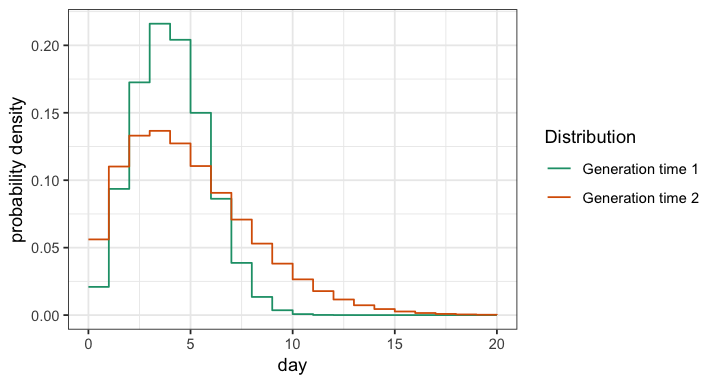

In [390]:
times = 1:21
cs = c(6,3.2)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])

clrs = c("#1b9e77","#d95f02","#7570b3")

data.frame(x=times, `Generation time 1`=h(times,solMLE$par[1:2]), `Generation time 2`=h(times,solMLE$par[3:4])) %>%
    gather(Variable,y,-x) %>%
    ggplot(aes(x=x-1,y=y)) +
        geom_step(aes(color=Variable)) +
        scale_color_manual(labels = c("Generation time 1", "Generation time 2"), values=clrs) +
        labs(x="day",y="probability density",color="Distribution")

# Main analysis 

## Loading the data

In [391]:
filename = "data.xlsx"

options(warn=-1)
read_excel(filename, sheet = "raw_onset") %>% ncol -> nclmns
read_excel(filename, sheet = "raw_onset", col_types = rep("date",nclmns)) %>%
    gather(epicurve,onset) %>% 
    mutate(number=1:n()) -> df
if (read_excel(filename, sheet = "raw_confirm") %>% ncol!=nclmns)
    message("Something wrong with number of columns in Excel file!")
read_excel(filename, sheet = "raw_confirm", col_types = rep("date",nclmns)) %>%
    gather(epicurve,confirmed) %>%
    mutate(number=1:n()) %>%
    left_join(df) %>%
    select(epicurve,onset,confirmed) %>%
    mutate(onset=as.Date(onset), confirmed=as.Date(confirmed)) -> df
options(warn=0)
df %>% tail

Joining, by = c("epicurve", "number")


epicurve,onset,confirmed
May27,2018-04-29,2018-05-12
May27,2018-05-09,2018-05-12
May27,2018-05-12,2018-05-13
May27,2018-05-08,2018-05-14
May27,2018-05-10,2018-05-15
May27,2018-05-12,2018-05-18


In [392]:
df %<>%
    mutate(difference=confirmed-onset,
           # if the onset date is unknown, it is assummed to be 5 days prior the confirmation
           difference=ifelse(is.na(onset),5,difference), 
           onset=if_else(is.na(as.numeric(onset)),confirmed-difference,onset)) %>%
    na.omit

# we shift the onset data of the index case to the date of first exposure 
df[which(df$onset=='2018-03-14'),'onset'] = as.Date('2018-03-17')

df %>% head

epicurve,onset,confirmed,difference
Apr01,2018-03-17,2018-03-20,6
Apr01,2018-03-27,2018-03-29,2
Apr01,2018-03-27,2018-03-29,2
Apr01,2018-03-25,2018-03-31,6
Apr01,2018-03-25,2018-03-31,6
Apr01,2018-03-26,2018-03-31,5


In [393]:
# total number of records
df %>% nrow

[1] 2066

We use Gamma distribution to define generation time distribution $g_t$, Weibull distribution for delay distribution $h_t$ between symptoms onset and lab confirmation

In [394]:
# Gamma distribution for incubation period
g = function(time) { 
    g_mean = 11.7; g_var = 9.0 # from (Klinkenberg and Nishiura 2011)
    scl = g_var/g_mean
    pgamma(time,shape=g_mean/scl,scale=scl)-pgamma(time-1,shape=g_mean/scl,scale=scl) }

In [395]:
# using days since index case instead of dates
(mindate = min(df$onset))
(maxdate = max(df$confirmed))
df %<>% 
    mutate(day_onset = unclass(onset)-unclass(mindate),
           day_confirmation = unclass(confirmed)-unclass(mindate))
df %>% head

[1] "2018-03-17"

[1] "2018-05-18"

epicurve,onset,confirmed,difference,day_onset,day_confirmation
Apr01,2018-03-17,2018-03-20,6,0,3
Apr01,2018-03-27,2018-03-29,2,10,12
Apr01,2018-03-27,2018-03-29,2,10,12
Apr01,2018-03-25,2018-03-31,6,8,14
Apr01,2018-03-25,2018-03-31,6,8,14
Apr01,2018-03-26,2018-03-31,5,9,14


In [396]:
# Available epicurves
(all_epicurves = unique(df$epicurve))
# we restrict ourselves to the following epicurves 
# starting from the first one with the time step of eight days
(all_epicurves = c("Apr01","Apr09","Apr17","Apr25","May03","May11","May17","May25"))
df = filter(df,epicurve %in% all_epicurves)

[1] "Apr01" "Apr05" "Apr09" "Apr13" "Apr17" "Apr21" "Apr25" "Apr29" "May01"
[10] "May03" "May05" "May07" "May09" "May11" "May13" "May15" "May17" "May19"
[19] "May21" "May23" "May25" "May27"

[1] "Apr01" "Apr09" "Apr17" "Apr25" "May03" "May11" "May17" "May25"

In [397]:
(maxDay = max(df$day_confirmation)+21)

[1] 83

# <font color="red">With no switch in delay function</font>

* **Slower version**

In [702]:
# if the parameter "prediction" is FALSE, the result of the function is log-likelihood,
# otherwise it give the resulting data.frame with all entities
calculate_six_generations = function(prms,prediction=FALSE,ndays=maxDay) {
    K = prms[1]; R2 = prms[2]; R3 = prms[3]; R4 = prms[4]; R5 = prms[5]
    
    data.frame(day = 0:ndays) %>%
        mutate(gt=g(day)) -> df_

    #calculating first convolution
    conv = c()
    for (x in 1:nrow(df_)) {
        conv = c(conv,sum(df_$gt[1:x]*df_$gt[x:1])) }
    df_ %<>% do(cbind(.,conv1_gt=conv))
    
    #calculating second convolution
    conv = c()
    for (x in 1:nrow(df_)) {
        conv = c(conv,sum(df_$conv1_gt[1:x]*df_$gt[x:1])) }
    df_ %<>% do(cbind(.,conv2_gt=conv))
    
    #calculating third convolution
    conv = c()
    for (x in 1:nrow(df_)) {
        conv = c(conv,sum(df_$conv2_gt[1:x]*df_$gt[x:1])) }
    df_ %<>% do(cbind(.,conv3_gt=conv))
    
    #calculating fourth convolution
    conv = c()
    for (x in 1:nrow(df_)) {
        conv = c(conv,sum(df_$conv3_gt[1:x]*df_$gt[x:1])) }
    df_ %<>% do(cbind(.,conv4_gt=conv))


    df_ %<>% 
        mutate(ft = (gt+R2*conv1_gt+R2*R3*conv2_gt+R2*R3*R4*conv3_gt+R2*R3*R4*R5*conv3_gt)/(1+R2+R2*R3+R2*R3*R4+R2*R3*R4*R5)) 
    
    if (prediction) {
        df_ %<>% 
            mutate(ht=h(day,prms[6:7]))
        
        #calculating convolution with h
        conv = c()
        for (x in 1:nrow(df_)) {
            conv = c(conv,sum(df_$ft[1:x]*df_$ht[x:1])) }
        df_ %<>% do(cbind(.,conv_ht=conv)) 

        df_ %>% 
            left_join(Df,by="day") %>%
            mutate(lambda_i = K*ft, lambda_c = K*conv_ht) %>%
            left_join(select(Df,-i,-c),by="day") %>% return
        
    } else {
        df_ %<>% right_join(Df,by="day") 
        
        maxday = max(df_$day)
        
        df_ %>%
            filter(ft>0 & day<maxday) %>% 
            mutate(lambda = H(maxday-day,prms[6:7])*K*ft) %>%
            summarize(loglk = sum(i*log(lambda)-lambda-lfactorial(i))) %>% 
            .$loglk -> loglk_onset
        
        df_current %>% 
            group_by(difference) %>%
            count %>% 
            ungroup %>%
            rowwise %>%
            mutate(loglk = n*log(h(difference,prms[6:7]))) %>% 
            ungroup %>%
            summarize(loglk = sum(loglk)) %>%
            .$loglk -> loglk_delay
        
        return(loglk_delay+loglk_onset)
    }
}

calculate_five_generations = function(x,prediction=FALSE,ndays=maxDay) { 
    calculate_six_generations(c(x[1:4],0,x[5:length(x)]),prediction,ndays) }
calculate_four_generations = function(x,prediction=FALSE,ndays=maxDay) { 
    calculate_six_generations(c(x[1:3],0,0,x[4:length(x)]),prediction,ndays) }
calculate_three_generations = function(x,prediction=FALSE,ndays=maxDay) { 
    calculate_six_generations(c(x[1:2],0,0,0,x[3:length(x)]),prediction,ndays) }
calculate_two_generations = function(x,prediction=FALSE,ndays=maxDay) { 
    calculate_six_generations(c(x[1],0,0,0,0,x[2:length(x)]),prediction,ndays) }

getDelay = function(prms) {
    df_current %>% 
        mutate(delta = day_confirmation-day_onset) %>%
        group_by(delta) %>%
        count %>%
        ungroup -> df_

    df_ %>% 
        right_join(data.frame(delta=1:max(df_$delta)+1),by="delta") %>%
        mutate(n = ifelse(is.na(n),0,n), ht = h(delta,prms)) %>%
        mutate(freq = n/sum(n)) %>%
        return
}

In [703]:
# test
pars = c(123.00059,1.25,1,2,4)
calculate_four_generations(pars)

[1] -368.6515

* **Faster (optimized) version** (it gives the same result as the one above)

In [645]:
# if the parameter "prediction" is FALSE, the result of the function is log-likelihood,
# otherwise it give the resulting data.frame with all entities
calculate_six_generations = function(prms,prediction=FALSE) {
    R2 = prms[1]; R3 = prms[2]; R4 = prms[3]; R5 = prms[4]
    
    maxday = ifelse(prediction,maxDay,max(Df$day))
    
    gt = g(0:maxday)

    #calculating first convolution
    conv1_gt = c()
    for (x in 1:length(gt)) {
        conv1_gt = c(conv1_gt,sum(gt[1:x]*gt[x:1])) }
    
    #calculating second convolution
    conv2_gt = c()
    for (x in 1:length(gt)) {
        conv2_gt = c(conv2_gt,sum(conv1_gt[1:x]*gt[x:1])) }
    
    #calculating third convolution
    conv3_gt = c()
    for (x in 1:length(gt)) {
        conv3_gt = c(conv3_gt,sum(conv2_gt[1:x]*gt[x:1])) }
    
    #calculating fourth convolution
    conv4_gt = c()
    for (x in 1:length(gt)) {
        conv4_gt = c(conv4_gt,sum(conv3_gt[1:x]*gt[x:1])) }
    
    ft = (gt+R2*conv1_gt+R2*R3*conv2_gt+R2*R3*R4*conv3_gt+R2*R3*R4*R5*conv3_gt)/(1+R2+R2*R3+R2*R3*R4+R2*R3*R4*R5)
    
    if (prediction) {
        K = sum(Df$i[-max(Df$day)])/sum(H(maxday:0,prms[5:6])*ft)
        
        ht=h(0:maxday,prms[5:6])
        
        #calculating convolution with h
        conv_ht = c()
        for (x in 1:length(ht)) {
            conv_ht = c(conv_ht,sum(ft[1:x]*ht[x:1])) }
        
        data.frame(
            day = 0:maxday,
            lambda_i = K*ft, 
            lambda_c = K*conv_ht) %>%
        left_join(Df,by="day") %>% return
        
    } else {
        K = sum(Df$i[-maxday])/sum(H(maxday:0,prms[5:6])*ft)
        Klast <<- K
        lambda = (H(maxday:0,prms[5:6])*ft*K)[-c(1,maxday+1)]
        
        loglk_onset = sum(Df$i[-c(1,maxday+1)]*log(lambda)-lambda-lfactorial(Df$i[-c(1,maxday+1)]))
        
        dt = table(df_current$difference) %>% { apply(as.matrix.noquote(data.frame(.)),2,as.numeric) }
        loglk_delay = sum(dt[,2]*log(h(dt[,1],prms[5:6])))
        
        return(loglk_delay+loglk_onset)
    }
}

calculate_five_generations = function(x,prediction=FALSE) { calculate_six_generations(c(x[1:3],0,x[4:length(x)]),prediction) }
calculate_four_generations = function(x,prediction=FALSE) { calculate_six_generations(c(x[1:2],0,0,x[3:length(x)]),prediction) }
calculate_three_generations = function(x,prediction=FALSE) { calculate_six_generations(c(x[1],0,0,0,x[2:length(x)]),prediction) }
calculate_two_generations = function(x,prediction=FALSE) { calculate_six_generations(c(0,0,0,0,x),prediction) }
                         
calculate_generations = function(ngenerations,x,prediction=FALSE) {
    switch(ngenerations,
           NULL,
           calculate_two_generations(x,prediction),
           calculate_three_generations(x,prediction),
           calculate_four_generations(x,prediction),
           calculate_five_generations(x,prediction),
           calculate_six_generations(x,prediction)
          )
}

In [646]:
# test
pars = c(1.25,1,2,4)
(calculate_four_generations(pars))
Klast

[1] -405.8745

[1] 123.0003

## Generating a table with varied number of generations

## Two generations

In [647]:
# File names to save the output

final_pars_output = "final_pars_constant_delay.csv"

recalc = TRUE

In [680]:
if (recalc) {
    final_pars = NULL

    # initial parameter values used in optim function
    pars = c(2,5)
    options(warn=-1)
    for (current_epicurve in unique(df$epicurve)[1:4]) { 
        message(current_epicurve)

        df %>% 
            filter(epicurve==current_epicurve) %>% 
            select(-epicurve) -> df_current

        Df = data.frame(day=0:(unclass(as.Date('2018'%&%current_epicurve,"%Y%b%d"))-unclass(dayZero)))

        df_current %>% 
            filter(day_onset>0) %>% #removing index case
            group_by(day_onset) %>%
            count %>%
            rename(day=day_onset) %>%
            right_join(Df,by="day") %>%
            mutate(n=ifelse(is.na(n),0,n)) %>%
            rename(i=n) -> Df

        df_current %>%
            filter(day_onset>0) %>% #removing index case
            group_by(day_confirmation) %>%
            count %>%
            rename(day=day_confirmation) %>%
            right_join(Df,by="day") %>%
            mutate(n=ifelse(is.na(n),0,n)) %>%
            rename(c=n) %>%
            select(day,i,c) %>%
            arrange(day) -> Df

        Df %>% mutate(date=day+dayZero) %>%
            select(date,day) %>% rename(onset=date) %>% right_join(df_current,by="onset") -> df_current

        solMLE = optim(pars,
                    function(x) calculate_generations(length(pars),x,FALSE),
                    method="L-BFGS-B",
                    control=list(fnscale=-1),lower=rep(0,length(pars)))   

        # Weibull distribution mean and variance
        parsH = solMLE$par[(length(pars)-1):length(pars)]
        pars_h = c(parsH[2]*gamma(1+1/parsH[1]),parsH[2]^2*(gamma(1+2/parsH[1])-(gamma(1+1/parsH[1]))^2))

        # Maximum likelihood estimates (MLE)
        calculate_generations(length(pars),solMLE$par,prediction=TRUE) %>% 
            rename(`MLE_i`=`lambda_i`,`MLE_c`=`lambda_c`) -> dfMLE

        # RMSE
        calculate_generations(length(pars),solMLE$par,prediction=TRUE) %>%
            na.omit %>%
            mutate(epsilon_i = (lambda_i-i), epsilon_c = (lambda_c-c)) %>%
            summarize(rmse_i = sqrt(sum(epsilon_i^2)/n()),rmse_c = sqrt(sum(epsilon_c^2)/n())) %>% as.numeric -> rmse

        npars = length(pars)
        output = data.frame(t(c(pars_h,solMLE$par[(length(pars)-1):length(pars)],
                                Klast,solMLE$value,2*(npars+1-solMLE$value),rmse))) #npars+2, additional two is due to tau and K
        colnames(output) = c("mean_h1","var_h1","par1_h1","par2_h1",
                             "K","loglk","AIC","rmse_i","rmse_c")

        print(output) 
        
        final_pars %<>% rbind(output %>% gather(parameter,estimate) %>% 
                mutate(epicurve=current_epicurve,generations=length(pars)))
    }        
}

message("Done")

Apr01


   mean_h1  var_h1  par1_h1  par2_h1        K     loglk      AIC   rmse_i
1 4.044729 3.93481 2.147092 4.567165 25.83603 -37.24594 80.49188 1.047905
    rmse_c
1 1.323245


Apr09


   mean_h1   var_h1  par1_h1  par2_h1       K     loglk      AIC   rmse_i
1 3.912038 3.872445 2.087287 4.416724 35.3243 -100.4916 206.9832 1.065747
    rmse_c
1 1.378465


Apr17


   mean_h1   var_h1  par1_h1  par2_h1        K    loglk    AIC   rmse_i
1 3.924118 2.913656 2.454589 4.424604 63.01257 -273.625 553.25 2.807909
    rmse_c
1 2.718949


Apr25


   mean_h1   var_h1  par1_h1  par2_h1        K     loglk      AIC   rmse_i
1 3.955826 2.918283 2.474559 4.459543 80.00003 -483.1434 972.2869 3.307684
    rmse_c
1 3.146875


Done


In [681]:
final_pars %>% spread(parameter,estimate)

epicurve,generations,AIC,K,loglk,mean_h1,par1_h1,par2_h1,rmse_c,rmse_i,var_h1
Apr01,2,80.49188,25.83603,-37.24594,4.044729,2.147092,4.567165,1.323245,1.047905,3.934810
Apr09,2,206.98325,35.32430,-100.49162,3.912038,2.087287,4.416724,1.378465,1.065747,3.872445
Apr17,2,553.24995,63.01257,-273.62498,3.924118,2.454589,4.424604,2.718949,2.807909,2.913656
Apr25,2,972.28686,80.00003,-483.14343,3.955826,2.474559,4.459543,3.146875,3.307684,2.918283


## Three and more generations

In [682]:
if (recalc) {
    for (J in 1:4) {
        pars = c(rep(1.,J),2,5)

        message("Number of generations ",J+2)

        # initial parameter values used in optim function
        options(warn=-1)
        for (current_epicurve in unique(df$epicurve)[ifelse(J==1,1,2):length(unique(df$epicurve))]) { 
            message(current_epicurve)

            df %>% 
                filter(epicurve==current_epicurve) %>% 
                select(-epicurve) -> df_current

            Df = data.frame(day=0:(unclass(as.Date('2018'%&%current_epicurve,"%Y%b%d"))-unclass(dayZero)))

            df_current %>% 
                filter(day_onset>0) %>% #removing index case
                group_by(day_onset) %>%
                count %>%
                rename(day=day_onset) %>%
                right_join(Df,by="day") %>%
                mutate(n=ifelse(is.na(n),0,n)) %>%
                rename(i=n) -> Df

            df_current %>%
                filter(day_onset>0) %>% #removing index case
                group_by(day_confirmation) %>%
                count %>%
                rename(day=day_confirmation) %>%
                right_join(Df,by="day") %>%
                mutate(n=ifelse(is.na(n),0,n)) %>%
                rename(c=n) %>%
                select(day,i,c) %>%
                arrange(day) -> Df

            Df %>% mutate(date=day+dayZero) %>%
                select(date,day) %>% rename(onset=date) %>% right_join(df_current,by="onset") -> df_current

            solMLE = optim(pars,
            function(x) calculate_generations(length(pars),x,FALSE),
            method="L-BFGS-B",
            control=list(fnscale=-1),lower=rep(0,length(pars)))   

            # Weibull distribution mean and variance
            parsH = solMLE$par[(length(pars)-1):length(pars)]
            pars_h = c(parsH[2]*gamma(1+1/parsH[1]),parsH[2]^2*(gamma(1+2/parsH[1])-(gamma(1+1/parsH[1]))^2))

            # Maximum likelihood estimates (MLE)
            calculate_generations(length(pars),solMLE$par,prediction=TRUE) %>% 
                rename(`MLE_i`=`lambda_i`,`MLE_c`=`lambda_c`) -> dfMLE

            # RMSE
            calculate_generations(length(pars),solMLE$par,prediction=TRUE) %>%
                na.omit %>%
                mutate(epsilon_i = (lambda_i-i), epsilon_c = (lambda_c-c)) %>%
                summarize(rmse_i = sqrt(sum(epsilon_i^2)/n()),rmse_c = sqrt(sum(epsilon_c^2)/n())) %>% as.numeric -> rmse

            npars = length(pars)
            output = data.frame(t(c(pars_h,solMLE$par[(length(pars)-1):length(pars)],
                                    Klast,solMLE$value,2*(npars+1-solMLE$value),rmse))) #npars+2, additional two is due to tau and K
            colnames(output) = c("mean_h1","var_h1","par1_h1","par2_h1",
                                 "K","loglk","AIC","rmse_i","rmse_c")

            final_pars %<>% rbind(output %>% gather(parameter,estimate) %>% 
                                  mutate(epicurve=current_epicurve,generations=length(pars)))
        }

#         final_pars %>%
#             write.table(file=final_pars_output, sep=",", col.names=T, append = T, quote = F, row.names = F)
    }
}

message("Done")

Number of generations 3
Apr01
Apr09
Apr17
Apr25
May03
May11
May17
May25
Number of generations 4
Apr09
Apr17
Apr25
May03
May11
May17
May25
Number of generations 5
Apr09
Apr17
Apr25
May03
May11
May17
May25
Number of generations 6
Apr09
Apr17
Apr25
May03
May11
May17
May25
Done


In [683]:
final_pars %>% spread(parameter,estimate) %>% mutate(switches=0,AIC=as.numeric(AIC)) %>% 
    group_by(epicurve) %>%
    filter(AIC==min(AIC)) %>%
    select(epicurve,generations,switches,AIC,loglk,everything()) -> final_pars_0

final_pars_0

epicurve,generations,switches,AIC,loglk,K,mean_h1,par1_h1,par2_h1,rmse_c,rmse_i,var_h1
Apr01,2,0,80.49188,-37.24594,25.83603,4.044729,2.147092,4.567165,1.323245,1.047905,3.934810
Apr09,3,0,204.12866,-98.06433,68.10538,4.061816,2.198336,4.586395,1.739619,1.472954,3.803674
Apr17,3,0,344.41905,-168.20953,75.92714,4.068596,2.497009,4.585688,1.641221,1.396995,3.037520
Apr25,4,0,448.09032,-219.04516,97.71981,4.038389,2.510051,4.551056,1.686684,1.430253,2.964801
May03,5,0,598.70950,-293.35475,142.08896,4.293683,2.176907,4.848302,1.909321,1.587827,4.325689
May11,5,0,703.15713,-345.57857,125.57604,4.480782,1.959805,5.053882,1.786760,1.375710,5.690231
May17,5,0,740.86426,-364.43213,124.34020,4.500895,1.889103,5.071254,1.703754,1.266656,6.134795
May25,5,0,749.90946,-368.95473,123.21179,4.509955,1.896179,5.082092,1.608431,1.204498,6.118089


# <font color="red">With a switch in delay function</font>

## As an example, we analyse first only one particular epicurve

In [686]:
(current_epicurve = all_epicurves %>% rev %>% .[3])

[1] "May11"

In [687]:
df %>% 
    filter(epicurve==current_epicurve) %>% 
    select(-epicurve) -> df_current

Df = data.frame(day=0:(unclass(as.Date('2018'%&%current_epicurve,"%Y%b%d"))-unclass(as.Date('2018-03-17'))))

df_current %>% 
    filter(day_onset>0) %>% #removing index case from fitting
    group_by(day_onset) %>%
    count %>%
    rename(day=day_onset) %>%
    right_join(Df,by="day") %>%
    mutate(n=ifelse(is.na(n),0,n)) %>%
    rename(i=n) -> Df

df_current %>%
    filter(day_onset>0) %>% #removing index case from fitting
    group_by(day_confirmation) %>%
    count %>%
    rename(day=day_confirmation) %>%
    right_join(Df,by="day") %>%
    mutate(n=ifelse(is.na(n),0,n)) %>%
    rename(c=n) %>%
    select(day,i,c) %>%
    arrange(day) -> Df

# Df %<>% mutate(date=day+as.Date('2018-03-17'))

Df %>% tail

day,i,c
50,2,0
51,1,0
52,0,3
53,0,2
54,0,1
55,0,4


In [688]:
Df %>% mutate(date=day+as.Date('2018-03-17')) %>%
    select(date,day) %>% rename(onset=date) %>% right_join(df_current) -> df_current

df_current %>% head

Joining, by = "onset"


onset,day,confirmed,difference,day_onset,day_confirmation
2018-03-17,0,2018-03-20,6,0,3
2018-03-27,10,2018-03-29,2,10,12
2018-03-27,10,2018-03-29,2,10,12
2018-03-25,8,2018-03-31,6,8,14
2018-03-25,8,2018-03-31,6,8,14
2018-03-26,9,2018-03-31,5,9,14


In [694]:
# if the parameter "prediction" is FALSE, the result of the function is log-likelihood,
# otherwise it give the resulting data.frame with all entities
calculate_six_generations = function(prms,tau,prediction=FALSE) {
    K = prms[1]; R2 = prms[2]; R3 = prms[3]; R4 = prms[4]; R5 = prms[5]
    
    maxday = max(Df$day)
    
    data.frame(day = 0:maxday) %>%
        mutate(gt=g(day)) -> df_

    #calculating first convolution
    conv = c()
    for (x in 1:nrow(df_)) {
        conv = c(conv,sum(df_$gt[1:x]*df_$gt[x:1])) }
    df_ %<>% do(cbind(.,conv1_gt=conv))
    
    #calculating second convolution
    conv = c()
    for (x in 1:nrow(df_)) {
        conv = c(conv,sum(df_$conv1_gt[1:x]*df_$gt[x:1])) }
    df_ %<>% do(cbind(.,conv2_gt=conv))
    
    #calculating third convolution
    conv = c()
    for (x in 1:nrow(df_)) {
        conv = c(conv,sum(df_$conv2_gt[1:x]*df_$gt[x:1])) }
    df_ %<>% do(cbind(.,conv3_gt=conv))
    
    #calculating fourth convolution
    conv = c()
    for (x in 1:nrow(df_)) {
        conv = c(conv,sum(df_$conv3_gt[1:x]*df_$gt[x:1])) }
    df_ %<>% do(cbind(.,conv4_gt=conv))


    df_ %<>% 
        mutate(ft = (gt+R2*conv1_gt+R2*R3*conv2_gt+R2*R3*R4*conv3_gt+R2*R3*R4*R5*conv3_gt)/(1+R2+R2*R3+R2*R3*R4+R2*R3*R4*R5)) 
    
    if (prediction) {
        df_ %<>% 
            mutate(hNum = ifelse(day<tau,0,1), ht=h(day,prms[6:7+2*hNum]))
        
        #calculating convolution with h
        conv = c()
        for (x in 1:nrow(df_)) {
            conv = c(conv,sum(df_$ft[1:x]*df_$ht[x:1])) }
        df_ %<>% do(cbind(.,conv_ht=conv)) 

        df_ %>% 
            left_join(Df,by="day") %>%
            mutate(lambda_i = K*ft, lambda_c = K*conv_ht) %>%
            left_join(select(Df,-i,-c),by="day") %>% return
        
    } else {
        df_ %<>% right_join(Df,by="day") 
        
        df_ %>%
            mutate(hNum = ifelse(day<tau,0,1)) %>%
            filter(ft>0 & day<maxday) %>%
            rowwise %>%
            mutate(lambda = H(maxday-day,prms[6:7+2*hNum])*K*ft) %>%
            ungroup %>%
            summarize(loglk = sum(i*log(lambda)-lambda-lfactorial(i))) %>% 
            .$loglk -> loglk_onset
                
        df_current %>% 
            mutate(hNum = ifelse(day<tau,0,1)) %>%
            group_by(hNum,difference) %>%
            count %>% 
            ungroup %>%
            rowwise %>%
            mutate(loglk = n*log(h(difference,prms[6:7+2*hNum]))) %>% 
            ungroup %>%
            summarize(loglk = sum(loglk)) %>%
            .$loglk -> loglk_delay
                
        return(loglk_delay+loglk_onset)
    }
}

calculate_five_generations = function(x,tau,prediction=FALSE) { calculate_six_generations(c(x[1:4],0,x[5:length(x)]),tau,prediction) }
calculate_four_generations = function(x,tau,prediction=FALSE) { calculate_six_generations(c(x[1:3],0,0,x[4:length(x)]),tau,prediction) }
calculate_three_generations = function(x,tau,prediction=FALSE) { calculate_six_generations(c(x[1:2],0,0,0,x[3:length(x)]),tau,prediction) }
calculate_two_generations = function(x,tau,prediction=FALSE) { calculate_six_generations(c(x[1],0,0,0,0,x[2:length(x)]),tau,prediction) }

In [699]:
# test
pars = c(118.10832,1.25,1,2,4,1,4)
tau0 = 30
calculate_four_generations(pars,tau=tau0)

[1] -Inf

In [700]:
# if the parameter "prediction" is FALSE, the result of the function is log-likelihood,
# otherwise it give the resulting data.frame with all entities
calculate_six_generations = function(prms,tau,prediction=FALSE) {
    R2 = prms[1]; R3 = prms[2]; R4 = prms[3]; R5 = prms[4]
    
    maxday = ifelse(prediction,maxDay,max(Df$day))

    gt = g(0:maxday)
    hNum = ifelse(0:maxday<tau,0,1)

    #calculating first convolution
    conv1_gt = c()
    for (x in 1:length(gt)) {
        conv1_gt = c(conv1_gt,sum(gt[1:x]*gt[x:1])) }
    
    #calculating second convolution
    conv2_gt = c()
    for (x in 1:length(gt)) {
        conv2_gt = c(conv2_gt,sum(conv1_gt[1:x]*gt[x:1])) }
    
    #calculating third convolution
    conv3_gt = c()
    for (x in 1:length(gt)) {
        conv3_gt = c(conv3_gt,sum(conv2_gt[1:x]*gt[x:1])) }
    
    #calculating fourth convolution
    conv4_gt = c()
    for (x in 1:length(gt)) {
        conv4_gt = c(conv4_gt,sum(conv3_gt[1:x]*gt[x:1])) }
    
    ft = (gt+R2*conv1_gt+R2*R3*conv2_gt+R2*R3*R4*conv3_gt+R2*R3*R4*R5*conv3_gt)/(1+R2+R2*R3+R2*R3*R4+R2*R3*R4*R5)
    
    if (prediction) {
        K = sum(Df$i[-max(Df$day)])/sum(mapply(function(x,y) H(x,prms[5:6+2*y]),maxday:0,hNum)*ft)
        
        ht=h(0:maxday,prms[5:6+2*hNum])
        
        #calculating convolution with h
        conv_ht = c()
        for (x in 1:length(ht)) {
            conv_ht = c(conv_ht,sum(ft[1:x]*ht[x:1])) }
        
        data.frame(
            day = 0:maxday,
            lambda_i = K*ft, 
            lambda_c = K*conv_ht) %>%
        left_join(Df,by="day") %>% return
        
    } else {
        K = sum(Df$i[-maxday])/sum(mapply(function(x,y) H(x,prms[5:6+2*y]),maxday:0,hNum)*ft)
        Klast <<- K
        lambda = (mapply(function(x,y) H(x,prms[5:6+2*y]),maxday:0,hNum)*ft*K)[-c(1,maxday+1)] 
        #the first and the last elements are zeros -> so we remove them due to non-zeros loglk
        
        loglk_onset = sum(Df$i[-c(1,maxday+1)]*log(lambda)-lambda-lfactorial(Df$i[-c(1,maxday+1)]))
                         
        dt = table(df_current[df_current$day<tau,]$difference) %>% { apply(as.matrix.noquote(data.frame(.)),2,as.numeric) }
        loglk_delay = sum(dt[,2]*log(h(dt[,1],prms[5:6])))     
        dt = table(df_current[df_current$day>=tau,]$difference) %>% { apply(as.matrix.noquote(data.frame(.)),2,as.numeric) }
        loglk_delay = loglk_delay + sum(dt[,2]*log(h(dt[,1],prms[7:8])))
        
        return(loglk_delay+loglk_onset)
    }
}

calculate_five_generations = function(x,tau,prediction=FALSE) { calculate_six_generations(c(x[1:3],0,x[4:length(x)]),tau,prediction) }
calculate_four_generations = function(x,tau,prediction=FALSE) { calculate_six_generations(c(x[1:2],0,0,x[3:length(x)]),tau,prediction) }
calculate_three_generations = function(x,tau,prediction=FALSE) { calculate_six_generations(c(x[1],0,0,0,x[2:length(x)]),tau,prediction) }
calculate_two_generations = function(x,tau,prediction=FALSE) { calculate_six_generations(c(0,0,0,0,x),tau,prediction) }
                         
calculate_generations = function(ngenerations,x,tau,prediction=FALSE) {
    switch(ngenerations,
           NULL,
           calculate_two_generations(x,tau,prediction),
           calculate_three_generations(x,tau,prediction),
           calculate_four_generations(x,tau,prediction),
           calculate_five_generations(x,tau,prediction),
           calculate_six_generations(x,tau,prediction)
          )
}

In [701]:
# test
pars = c(1.25,1,2,4,1,4)
tau0 = 30
calculate_generations(length(pars)-2,pars,tau=tau0)
Klast 

[1] -361.117

[1] 118.1083

In [606]:
options(warn=-1)
sol = optim(pars,function(x) calculate_generations(length(pars)-2,x,tau0,FALSE),
            method="L-BFGS-B",control=list(fnscale=-1),lower=rep(0,length(pars)),
            hessian=TRUE)
options(warn=0)
pars = sol$par 

print(Klast)
sol

[1] 123.0034


-13.353162174,-7.422934679,0.000000e+00,0.000000e+00,-2.519727e-03,7.934560e-04
-7.422934679,-11.563854201,0.000000e+00,0.000000e+00,-4.638849e-03,1.460904e-03
0.000000000,0.000000000,-1.510995e+01,5.211001e+00,1.421085e-08,0.000000e+00
0.000000000,0.000000000,5.211001e+00,-2.051499e+01,7.105427e-09,7.105427e-09
-0.002519727,-0.004638849,1.421085e-08,7.105427e-09,-3.624502e+01,4.538160e+00
0.000793456,0.001460904,0.000000e+00,7.105427e-09,4.538160e+00,-4.970228e+00


In [607]:
# Obtained Weibull distribution mean and variance
for (j in c(1,0)) {
    parsH = pars[(length(pars)-1):length(pars)-2*j]
    c(parsH[2]*gamma(1+1/parsH[1]),parsH[2]^2*(gamma(1+2/parsH[1])-(gamma(1+1/parsH[1]))^2)) %>% print
}

[1] 4.164112 2.975304
[1] 4.929124 9.421072


In [608]:
calculate_generations(4,pars,tau=tau0,prediction=TRUE) -> dfMLE 
dfMLE %>% tail(10)

,day,lambda_i,lambda_c,i,c
75,74,3.966457e-07,1.655239e-05,NA,NA
76,75,1.995136e-07,8.872014e-06,NA,NA
77,76,9.952771e-08,4.709334e-06,NA,NA
78,77,4.925079e-08,2.476212e-06,NA,NA
79,78,2.418087e-08,1.290085e-06,NA,NA
80,79,1.178173e-08,6.661285e-07,NA,NA
81,80,5.697823e-09,3.409644e-07,NA,NA
82,81,2.735609e-09,1.730495e-07,NA,NA
83,82,1.304136e-09,8.710382e-08,NA,NA
84,83,6.174356e-10,4.349115e-08,NA,NA


Warning message:
“Removed 14 rows containing missing values (geom_bar).”Warning message:
“Removed 14 rows containing missing values (geom_bar).”

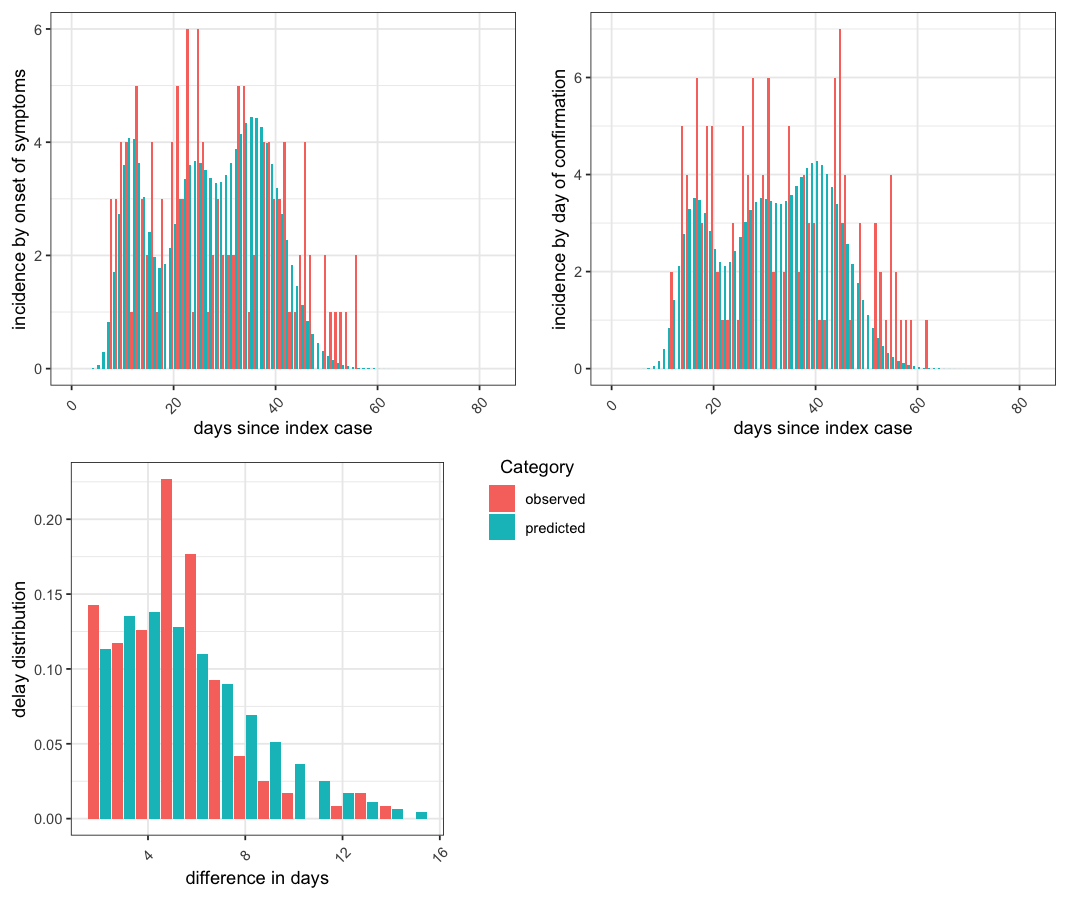

In [609]:
options(repr.plot.width=9,repr.plot.height=7.5)
xmax = max(dfMLE$day)

dfMLE %>%
    select(one_of("day","lambda_i","i")) %>%
    rename(pred=lambda_i,obs=i) %>%
    gather(Category,Count,-day) %>%
    mutate(Category=factor(Category,levels=c("pred","obs") %>% rev)) %>%
    ggplot(aes(x=day)) +
        geom_bar(aes(y=Count,fill=Category),stat="identity",position=position_dodge(1)) +
        coord_cartesian(xlim=c(0,xmax)) +
        guides(fill=F) +
        labs(y="incidence by onset of symptoms",x="days since index case") +
        theme(axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              strip.background = element_rect(colour="white", fill="white"),
              legend.position=c(.2,.87),
              plot.margin = unit(c(.5,1,.5,.5),"lines"),
              legend.direction="horizontal") -> plt_onset

dfMLE %>%
    select(one_of("day","lambda_c","c")) %>%
    rename(pred=lambda_c,obs=c) %>%
    gather(Category,Count,-day) %>%
    mutate(Category=factor(Category,levels=c("pred","obs") %>% rev)) %>%
    ggplot(aes(x=day)) +
        geom_bar(aes(y=Count,fill=Category),stat="identity",position=position_dodge(1)) +
        coord_cartesian(xlim=c(0,xmax)) +
        guides(fill=F) +
        labs(y="incidence by day of confirmation",x="days since index case") +
        theme(axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              strip.background = element_rect(colour="white", fill="white"),
              legend.position=c(.2,.87),
              plot.margin = unit(c(.5,1,.5,.5),"lines"),
              legend.direction="horizontal") -> plt_confirmation

getDelay(parsH[1:2]) %>%
    select(delta,ht,freq) %>%
    rename(predicted=ht,observed=freq) %>%
    gather(Category,Count,-delta) %>%
    mutate(Category=factor(Category,levels=c("predicted","observed") %>% rev)) %>%
    ggplot(aes(x=delta)) +
        geom_bar(aes(y=Count,fill=Category),stat="identity",position=position_dodge(1)) +
        guides(fill=guide_legend(title.hjust = 0.5)) +
        labs(y="delay distribution",x="difference in days") +
        theme(axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              strip.background = element_rect(colour="white", fill="white"),
              legend.position=c(1.25,.9),
              plot.margin = unit(c(.5,4,.5,.5),"lines")
             ) -> plt_delay

grid.arrange(ggplotGrob(plt_onset), ggplotGrob(plt_confirmation), ggplotGrob(plt_delay),
                 widths=c(1,1), heights=c(1,1), nrow=2, ncol=2)

## Generating a table with varied number of generations

## Two generations

In [610]:
# File names to save the output

final_pars_output = "final_pars_varied_delay.csv"

recalc = TRUE

In [611]:
if (recalc) {
    final_pars = NULL

    # initial parameter values used in optim function
    pars = c(2,5,3,4)
    options(warn=-1)
    for (current_epicurve in unique(df$epicurve)[1:4]) { 
        message(current_epicurve)

        df %>% 
            filter(epicurve==current_epicurve) %>% 
            select(-epicurve) -> df_current

        Df = data.frame(day=0:(unclass(as.Date('2018'%&%current_epicurve,"%Y%b%d"))-unclass(dayZero)))

        df_current %>% 
            filter(day_onset>0) %>% #removing index case
            group_by(day_onset) %>%
            count %>%
            rename(day=day_onset) %>%
            right_join(Df,by="day") %>%
            mutate(n=ifelse(is.na(n),0,n)) %>%
            rename(i=n) -> Df

        df_current %>%
            filter(day_onset>0) %>% #removing index case
            group_by(day_confirmation) %>%
            count %>%
            rename(day=day_confirmation) %>%
            right_join(Df,by="day") %>%
            mutate(n=ifelse(is.na(n),0,n)) %>%
            rename(c=n) %>%
            select(day,i,c) %>%
            arrange(day) -> Df

        Df %>% mutate(date=day+dayZero) %>%
            select(date,day) %>% rename(onset=date) %>% right_join(df_current,by="onset") -> df_current

        foreach(
            tau0=1:max(Df$day),
            .inorder=FALSE,
            .combine=rbind
        ) %dopar% {
            # we require that there would be at least two cases present in each subgroup day<tau0 and day>=tau0
            # to estimate the delay function
            if (nrow(df_current[df_current$day<tau0,])>1 & nrow(df_current[df_current$day>=tau0,])>1) {
                tryCatch({
                    sol = optim(pars,
                                function(x) calculate_generations(length(pars)-2,x,tau0,FALSE),
                                method="L-BFGS-B",
                                control=list(fnscale=-1),lower=rep(0,length(pars)))

                }, error=function(cond){print(cond)})
                data.frame(tau=tau0,loglk=sol$value) 
            }
        } -> output
        
        tauOptim = output[output$loglk==min(output$loglk),]$tau
        solMLE = optim(pars,
                    function(x) calculate_generations(length(pars)-2,x,tauOptim,FALSE),
                    method="L-BFGS-B",
                    control=list(fnscale=-1),lower=rep(0,length(pars)))      

        # Weibull distribution mean and variance
        pars_h = NULL
        for (j in c(1,0)) {
            parsH = solMLE$par[(length(pars)-1):length(pars)-2*j]
            pars_h = c(pars_h,parsH[2]*gamma(1+1/parsH[1]),parsH[2]^2*(gamma(1+2/parsH[1])-(gamma(1+1/parsH[1]))^2))
        }

        # Maximum likelihood estimates (MLE)
        calculate_generations(length(pars)-2,solMLE$par,tauOptim,prediction=TRUE) %>% 
            rename(`MLE_i`=`lambda_i`,`MLE_c`=`lambda_c`) -> dfMLE

        # RMSE
        calculate_generations(length(pars)-2,solMLE$par,tauOptim,prediction=TRUE) %>%
            na.omit %>%
            mutate(epsilon_i = (lambda_i-i), epsilon_c = (lambda_c-c)) %>%
            summarize(rmse_i = sqrt(sum(epsilon_i^2)/n()),rmse_c = sqrt(sum(epsilon_c^2)/n())) %>% as.numeric -> rmse

        npars = length(pars)
        output = data.frame(t(c(tauOptim,format(tauOptim+dayZero,"%b%d"),pars_h,solMLE$par[(length(pars)-3):length(pars)],
                                Klast,solMLE$value,2*(npars+2-solMLE$value),rmse))) #npars+2, additional two is due to tau and K
        colnames(output) = c("tau","tauDate","mean_h1","var_h1","mean_h2","var_h2","par1_h1","par2_h1","par1_h2","par2_h2",
                             "K","loglk","AIC","rmse_i","rmse_c")

        print(output) 
        
        final_pars %<>% rbind(output %>% gather(parameter,estimate) %>% mutate(epicurve=current_epicurve,generations=length(pars)-2))
    }        
}

message("Done")

Apr01


  tau tauDate          mean_h1           var_h1          mean_h2
1  11   Mar28 4.39261974206625 2.15723612019564 15.8632955671376
           var_h2          par1_h1          par2_h1           par1_h2
1 576.28916521169 3.29214419896964 4.89751372380707 0.679587778597602
           par2_h2                K            loglk              AIC
1 12.1724916006851 25.7214952411322 -34.684237256966 81.3684745139319
            rmse_i           rmse_c
1 1.04623327906771 1.32605375975963


Apr09


  tau tauDate          mean_h1           var_h1          mean_h2
1  11   Mar28 4.85769940403676 3.61434903114529 3.52583373136126
            var_h2          par1_h1          par2_h1          par1_h2
1 3.48954274969282 2.76211647102766 5.45809541516427 1.97029717149529
           par2_h2                K             loglk              AIC
1 3.97727781721449 35.0355813933096 -98.6048729781976 209.209745956395
            rmse_i           rmse_c
1 1.06574704315339 1.26201945488843


Apr17


  tau tauDate          mean_h1           var_h1          mean_h2
1  25   Apr11 4.06451929564343 3.13905258186457 3.54205046927915
            var_h2          par1_h1          par2_h1          par1_h2
1 2.02089951503946 2.44883174002025 4.58314630857084 2.68553441530877
           par2_h2                K             loglk              AIC
1 3.98376487278347 63.0113375194584 -272.559218476996 557.118436953991
            rmse_i           rmse_c
1 2.80790871197967 2.68774033235645


Apr25


  tau tauDate          mean_h1           var_h1          mean_h2
1  25   Apr11 4.08194906506144 3.22344344701682 3.78400463726382
            var_h2          par1_h1          par2_h1          par1_h2
1 2.39987850682853 2.42437964407475 4.60376241511706 2.62661077535302
           par2_h2                K             loglk              AIC
1 4.25894054945247 80.0000175967625 -482.529254241974 977.058508483948
            rmse_i           rmse_c
1 3.30768368190519 3.11272423867898


Done


In [612]:
final_pars %>% spread(parameter,estimate)

epicurve,generations,AIC,K,loglk,mean_h1,mean_h2,par1_h1,par1_h2,par2_h1,par2_h2,rmse_c,rmse_i,tau,tauDate,var_h1,var_h2
Apr01,2,81.3684745139319,25.7214952411322,-34.684237256966,4.39261974206625,15.8632955671376,3.29214419896964,0.679587778597602,4.89751372380707,12.1724916006851,1.32605375975963,1.04623327906771,11,Mar28,2.15723612019564,576.28916521169
Apr09,2,209.209745956395,35.0355813933096,-98.6048729781976,4.85769940403676,3.52583373136126,2.76211647102766,1.97029717149529,5.45809541516427,3.97727781721449,1.26201945488843,1.06574704315339,11,Mar28,3.61434903114529,3.48954274969282
Apr17,2,557.118436953991,63.0113375194584,-272.559218476996,4.06451929564343,3.54205046927915,2.44883174002025,2.68553441530877,4.58314630857084,3.98376487278347,2.68774033235645,2.80790871197967,25,Apr11,3.13905258186457,2.02089951503946
Apr25,2,977.058508483948,80.0000175967625,-482.529254241974,4.08194906506144,3.78400463726382,2.42437964407475,2.62661077535302,4.60376241511706,4.25894054945247,3.11272423867898,3.30768368190519,25,Apr11,3.22344344701682,2.39987850682853


## Three and more generations

In [613]:
if (recalc) {
    for (J in 1:4) {
        pars = c(rep(1.,J),2,5,3,4)

        message("Number of generations ",J+2)

        # initial parameter values used in optim function
        options(warn=-1)
        for (current_epicurve in unique(df$epicurve)[ifelse(J==1,1,2):length(unique(df$epicurve))]) { 
            message(current_epicurve)

            df %>% 
                filter(epicurve==current_epicurve) %>% 
                select(-epicurve) -> df_current

            Df = data.frame(day=0:(unclass(as.Date('2018'%&%current_epicurve,"%Y%b%d"))-unclass(dayZero)))

            df_current %>% 
                filter(day_onset>0) %>% #removing index case
                group_by(day_onset) %>%
                count %>%
                rename(day=day_onset) %>%
                right_join(Df,by="day") %>%
                mutate(n=ifelse(is.na(n),0,n)) %>%
                rename(i=n) -> Df

            df_current %>%
                filter(day_onset>0) %>% #removing index case
                group_by(day_confirmation) %>%
                count %>%
                rename(day=day_confirmation) %>%
                right_join(Df,by="day") %>%
                mutate(n=ifelse(is.na(n),0,n)) %>%
                rename(c=n) %>%
                select(day,i,c) %>%
                arrange(day) -> Df

            Df %>% mutate(date=day+dayZero) %>%
                select(date,day) %>% rename(onset=date) %>% right_join(df_current,by="onset") -> df_current

            foreach(
                tau0=1:max(Df$day),
                .inorder=FALSE,
                .combine=rbind
            ) %dopar% {
                # we require that there would be at least two cases present in each subgroup day<tau0 and day>=tau0
                # to estimate the delay function
                if (nrow(df_current[df_current$day<tau0,])>1 & nrow(df_current[df_current$day>=tau0,])>1) {
                    tryCatch({
                        sol = optim(pars,
                                    function(x) calculate_generations(length(pars)-2,x,tau0,FALSE),
                                    method="L-BFGS-B",
                                    control=list(fnscale=-1),lower=rep(0,length(pars)))

                    }, error=function(cond){print(cond)})
                    data.frame(tau=tau0,loglk=sol$value) 
                }
            } -> output

            tauOptim = output[output$loglk==min(output$loglk),]$tau
            solMLE = optim(pars,
                        function(x) calculate_generations(length(pars)-2,x,tauOptim,FALSE),
                        method="L-BFGS-B",
                        control=list(fnscale=-1),lower=rep(0,length(pars)))      

            # Weibull distribution mean and variance
            pars_h = NULL
            for (j in c(1,0)) {
                parsH = solMLE$par[(length(pars)-1):length(pars)-2*j]
                pars_h = c(pars_h,parsH[2]*gamma(1+1/parsH[1]),parsH[2]^2*(gamma(1+2/parsH[1])-(gamma(1+1/parsH[1]))^2))
            }

            # Maximum likelihood estimates (MLE)
            calculate_generations(length(pars)-2,solMLE$par,tauOptim,prediction=TRUE) %>% 
                rename(`MLE_i`=`lambda_i`,`MLE_c`=`lambda_c`) -> dfMLE

            # RMSE
            calculate_generations(length(pars)-2,solMLE$par,tauOptim,prediction=TRUE) %>%
                na.omit %>%
                mutate(epsilon_i = (lambda_i-i), epsilon_c = (lambda_c-c)) %>%
                summarize(rmse_i = sqrt(sum(epsilon_i^2)/n()),rmse_c = sqrt(sum(epsilon_c^2)/n())) %>% as.numeric -> rmse

            npars = length(pars)
            output = data.frame(t(c(tauOptim,format(tauOptim+dayZero,"%b%d"),pars_h,solMLE$par[(length(pars)-3):length(pars)],
                                    Klast,solMLE$par[1:(length(pars)-4)],solMLE$value,2*(npars+2-solMLE$value),rmse))) #npars+2, additional two is due to tau and K
            colnames(output) = c("tau","tauDate","mean_h1","var_h1","mean_h2","var_h2","par1_h1","par2_h1","par1_h2","par2_h2",
                                 "K",c("R"%&%(2:(J+1))),"loglk","AIC","rmse_i","rmse_c")

            final_pars %<>% rbind(output %>% gather(parameter,estimate) %>% mutate(epicurve=current_epicurve,generations=length(pars)-2))
        }

#         final_pars %>%
#             write.table(file=final_pars_output, sep=",", col.names=T, append = T, quote = F, row.names = F)
    }
}

message("Done")

Number of generations 3
Apr01
Apr09
Apr17
Apr25
May03
May11
May17
May25
Number of generations 4
Apr09
Apr17
Apr25
May03
May11
May17
May25
Number of generations 5
Apr09
Apr17
Apr25
May03
May11
May17
May25
Number of generations 6
Apr09
Apr17
Apr25
May03
May11
May17
May25
Done


In [615]:
final_pars %>% spread(parameter,estimate) %>% mutate(switches=1,AIC=as.numeric(AIC)) %>% 
    group_by(epicurve) %>%
    filter(AIC==min(AIC)) %>%
    select(epicurve,generations,switches,tau,tauDate,AIC,loglk,everything()) -> final_pars_1

final_pars_1

epicurve,generations,switches,tau,tauDate,AIC,loglk,K,mean_h1,mean_h2,⋯,par2_h1,par2_h2,R2,R3,R4,R5,rmse_c,rmse_i,var_h1,var_h2
Apr01,2,1,11,Mar28,81.36847,-34.684237256966,25.7214952411322,4.39261974206625,15.8632955671376,⋯,4.89751372380707,12.1724916006851,NA,NA,NA,NA,1.32605375975963,1.04623327906771,2.15723612019564,576.28916521169
Apr09,3,1,11,Mar28,207.33255,-96.6662748386242,60.2895795114935,4.85770704953967,3.69625810354917,⋯,5.45810190607804,4.17313909916096,0.938204013050874,NA,NA,NA,1.65257582384111,1.37108865315557,3.61429234113563,3.45079785938826
Apr17,3,1,24,Apr10,349.97873,-167.989362695309,74.8567474055801,4.12754035190309,3.83864567289574,⋯,4.65235547933193,4.31954174900719,1.52056513218552,NA,NA,NA,1.63698491106471,1.39295753538536,3.13768164668648,2.44055852699261
Apr25,4,1,24,Apr10,453.49034,-218.745170913519,96.7004494668245,4.13061282591808,3.88698188292152,⋯,4.65601824147714,4.37606300877655,1.34497323550277,0.682766793769655,NA,NA,1.68248531252477,1.41902009832542,3.15243377995387,2.57420036679525
May03,5,1,18,Apr04,604.58221,-293.291105873806,142.58193932563,4.22840976750387,4.32212576080639,⋯,4.77400308065313,4.88042735000877,1.35127312524472,0.762184264216391,1.33299932786755,NA,1.90872521902767,1.59169160602257,3.97017104257187,4.44497592287493
May11,5,1,46,May02,708.88241,-345.441204439372,125.096302856719,4.49644882836824,4.30953027749635,⋯,5.07285007468628,4.83674846685538,1.33156063772753,0.859395020126123,0.602897811877632,NA,1.78607827145316,1.37341945956787,5.61110745255885,6.54440633904988
May17,5,1,45,May01,746.59086,-364.295429755597,124.330347135645,4.51689766307128,4.39175076023365,⋯,5.09139084604299,4.92223999798765,1.32487775309026,0.89227757248556,0.534189719706446,NA,1.70295529989808,1.26665701540375,6.03510496184518,7.06699281598868
May25,5,1,45,May01,755.77219,-368.886094207811,123.221153324218,4.51692824690608,4.46519189799003,⋯,5.09142086775798,5.01534276539032,1.32099997730367,0.912124223119201,0.4770083009882,NA,1.60783400076436,1.20447585744382,6.03550451244207,6.85730326272724


In [684]:
rbind(
    final_pars_0 %>% mutate_all(funs(as.numeric(.))),
    final_pars_1 %>% mutate_all(funs(as.numeric(.)))) %>%
    group_by(epicurve) %>%
    filter(AIC==min(AIC)) %>%
    arrange(epicurve)

epicurve,generations,switches,AIC,loglk,K,mean_h1,par1_h1,par2_h1,rmse_c,⋯,tau,tauDate,mean_h2,par1_h2,par2_h2,R2,R3,R4,R5,var_h2
Apr01,2,0,80.49188,-37.24594,25.83603,4.044729,2.147092,4.567165,1.323245,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Apr09,3,0,204.12866,-98.06433,68.10538,4.061816,2.198336,4.586395,1.739619,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Apr17,3,0,344.41905,-168.20953,75.92714,4.068596,2.497009,4.585688,1.641221,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Apr25,4,0,448.09032,-219.04516,97.71981,4.038389,2.510051,4.551056,1.686684,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
May03,5,0,598.70950,-293.35475,142.08896,4.293683,2.176907,4.848302,1.909321,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
May11,5,0,703.15713,-345.57857,125.57604,4.480782,1.959805,5.053882,1.786760,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
May17,5,0,740.86426,-364.43213,124.34020,4.500895,1.889103,5.071254,1.703754,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
May25,5,0,749.90946,-368.95473,123.21179,4.509955,1.896179,5.082092,1.608431,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [707]:
final_pars_1

epicurve,generations,switches,tau,tauDate,AIC,loglk,K,mean_h1,mean_h2,⋯,par2_h1,par2_h2,R2,R3,R4,R5,rmse_c,rmse_i,var_h1,var_h2
Apr01,2,1,11,Mar28,81.36847,-34.684237256966,25.7214952411322,4.39261974206625,15.8632955671376,⋯,4.89751372380707,12.1724916006851,NA,NA,NA,NA,1.32605375975963,1.04623327906771,2.15723612019564,576.28916521169
Apr09,3,1,11,Mar28,207.33255,-96.6662748386242,60.2895795114935,4.85770704953967,3.69625810354917,⋯,5.45810190607804,4.17313909916096,0.938204013050874,NA,NA,NA,1.65257582384111,1.37108865315557,3.61429234113563,3.45079785938826
Apr17,3,1,24,Apr10,349.97873,-167.989362695309,74.8567474055801,4.12754035190309,3.83864567289574,⋯,4.65235547933193,4.31954174900719,1.52056513218552,NA,NA,NA,1.63698491106471,1.39295753538536,3.13768164668648,2.44055852699261
Apr25,4,1,24,Apr10,453.49034,-218.745170913519,96.7004494668245,4.13061282591808,3.88698188292152,⋯,4.65601824147714,4.37606300877655,1.34497323550277,0.682766793769655,NA,NA,1.68248531252477,1.41902009832542,3.15243377995387,2.57420036679525
May03,5,1,18,Apr04,604.58221,-293.291105873806,142.58193932563,4.22840976750387,4.32212576080639,⋯,4.77400308065313,4.88042735000877,1.35127312524472,0.762184264216391,1.33299932786755,NA,1.90872521902767,1.59169160602257,3.97017104257187,4.44497592287493
May11,5,1,46,May02,708.88241,-345.441204439372,125.096302856719,4.49644882836824,4.30953027749635,⋯,5.07285007468628,4.83674846685538,1.33156063772753,0.859395020126123,0.602897811877632,NA,1.78607827145316,1.37341945956787,5.61110745255885,6.54440633904988
May17,5,1,45,May01,746.59086,-364.295429755597,124.330347135645,4.51689766307128,4.39175076023365,⋯,5.09139084604299,4.92223999798765,1.32487775309026,0.89227757248556,0.534189719706446,NA,1.70295529989808,1.26665701540375,6.03510496184518,7.06699281598868
May25,5,1,45,May01,755.77219,-368.886094207811,123.221153324218,4.51692824690608,4.46519189799003,⋯,5.09142086775798,5.01534276539032,1.32099997730367,0.912124223119201,0.4770083009882,NA,1.60783400076436,1.20447585744382,6.03550451244207,6.85730326272724


In [721]:
epicurve	generations	tauDate	mean h1t	var h1t	mean h2t	var h2t	K	R2	R3	R4	R5	negloglk	AIC
Apr01	2	Mar28	4.39	2.16	15.86	576.29	25.7					34.7	81.4
Apr09	3	Mar28	4.86	3.61	3.70	3.45	60.3	0.94				96.7	207.3
Apr17	3	Apr10	4.13	3.14	3.84	2.44	74.9	1.52				168.0	350.0
Apr25	4	Apr10	4.13	3.15	3.89	2.57	96.7	1.34	0.68			218.7	453.5
May03	5	Apr04	4.23	3.97	4.32	4.44	142.6	1.35	0.76	1.33		293.3	604.6
May11	5	May02	4.50	5.61	4.31	6.54	125.1	1.33	0.86	0.60		345.4	708.9
May17	5	May01	4.52	6.04	4.39	7.07	124.3	1.32	0.89	0.53		364.3	746.6
May25	5	May01	4.52	6.04	4.47	6.86	123.2	1.32	0.91	0.48		368.9	755.8# a bit nicer form
options(warn=-1)
final_pars_1 %>% 
    arrange(epicurve,generations) %>%
    group_by(epicurve) %>%
    mutate(
           `mean h1t`= sprintf("%0.2f",mean_h1%>%as.numeric),
           `var h1t`=sprintf("%0.2f",var_h1%>%as.numeric),
           `mean h2t`= sprintf("%0.2f",mean_h2%>%as.numeric),
           `var h2t`=sprintf("%0.2f",var_h2%>%as.numeric),
           K=sprintf("%0.1f",K%>%as.numeric),
           R2=ifelse(!is.na(R2),
                     sprintf("%0.2f",R2%>%as.numeric),
                     ''),
           R3=ifelse(!is.na(R3),
                     sprintf("%0.2f",R3%>%as.numeric),
                     ''),
           R4=ifelse(!is.na(R4),
                     sprintf("%0.2f",R4%>%as.numeric),
                     ''),
           R5=ifelse(!is.na(R5),
                     sprintf("%0.2f",R5%>%as.numeric),
                     ''),
           negloglk=sprintf("%.1f",-as.numeric(loglk)),
           AIC=sprintf("%.1f",AIC)
          ) %>%
    select(epicurve,generations,tauDate,`mean h1t`,`var h1t`,`mean h2t`,`var h2t`,K,R2,R3,R4,R5,negloglk,AIC) -> pars_final_kabble#


pars_final_kabble %>%
    kable("html", escape = F) %>%
    kable_styling("hover", full_width = F) %>%
    as.character() %>%
    display_html()
options(warn=0)

epicurve,generations,tauDate,mean h1t,var h1t,mean h2t,var h2t,K,R2,R3,R4,R5,negloglk,AIC
Apr01,2,Mar28,4.39,2.16,15.86,576.29,25.7,,,,,34.7,81.4
Apr09,3,Mar28,4.86,3.61,3.70,3.45,60.3,0.94,,,,96.7,207.3
Apr17,3,Apr10,4.13,3.14,3.84,2.44,74.9,1.52,,,,168.0,350.0
Apr25,4,Apr10,4.13,3.15,3.89,2.57,96.7,1.34,0.68,,,218.7,453.5
May03,5,Apr04,4.23,3.97,4.32,4.44,142.6,1.35,0.76,1.33,,293.3,604.6
May11,5,May02,4.50,5.61,4.31,6.54,125.1,1.33,0.86,0.60,,345.4,708.9
May17,5,May01,4.52,6.04,4.39,7.07,124.3,1.32,0.89,0.53,,364.3,746.6
May25,5,May01,4.52,6.04,4.47,6.86,123.2,1.32,0.91,0.48,,368.9,755.8
